## LAB 2 - TASK 3 submission. ML 2023-24
FILL UP THIS BOX WITH YOUR DETAILS

**NAME AND NIP**:

- Ignacio Pastore Benaim, 920576
- David Padilla Orenga, 946874


## 3. Fine-tunning
Now we going to fine-tune a well known CNN architecture for image classification that has already been trained in ImageNet. We are going to fine-tune this for our own toy-dataset.

## Get data and tensorflow imports ready



In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import backend as K

from tensorflow.keras import optimizers
from tensorflow.keras.applications import VGG16

import matplotlib.pyplot as plt

In [2]:
# GET YOUR IMAGES READY

# OPTION A: upload and unzip, untar ... images if necessary (not recommended ... it'll only last one session)
#!tar -xvzf images.tar.gz
# !unzip toy-data.zip
# !ls

data_dir = '/Users/ignaciopastorebenaim/Documents/MGRCV/TPs/ML/Lab4/data/mini-mini-flowers' # Update this path to point to your data directory


# OPTION B: mount your google drive to point the code to find the data in your drive folders
# (instructions here: https://colab.research.google.com/notebooks/io.ipynb#scrollTo=u22w3BFiOveA)

In [3]:
# SOME HELPER FUNCTIONS TO VISUALIZE RESULTS
def vis_history(results_history):
    acc = results_history.history['accuracy']
    val_acc = results_history.history['val_accuracy']

    loss = results_history.history['loss']
    val_loss = results_history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [4]:
####### ***** TO-DO-LAB *****  #######
# make sure you config these params to fit what you want/need to LOAD YOUR DATA
# dimensions we will use with our images (they'll be resized if not this shape)
img_width, img_height = 224, 224 # TO MATCH THE SIZES OF THE BASE MODEL WE WANT TO USE, MOBILENET
# MODIFY THE PATH TO POINT TO YOUR DATA! locally here or in your mounted drive
# data_dir = 'toy-data' # all in one folder and let the system do the split
nb_train_samples = 160 # UPDATE WITH YOUR NUMBERS!!
nb_validation_samples = 40 # UPDATE WITH YOUR NUMBERS!!
batch_size = 4 #16
num_classes = 5
####### ***** TO-DO-LAB *****  #######

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# for more optimized handling of the data
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 200 files belonging to 5 classes.
Using 160 files for training.
Found 200 files belonging to 5 classes.
Using 40 files for validation.


2024-11-20 19:43:57.755228: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-11-20 19:43:57.755296: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-11-20 19:43:57.755326: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-11-20 19:43:57.756327: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-20 19:43:57.757403: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Let's do the fine-tunning


Let's load the base model, and modify the final classification layers to adapt to our 5-class toy-dataset. In this example we are fine-tuning MobileNetV2.

There are plenty of base models you could use, this is a pretty good compromise quality vs speed. Many more models in: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [ ]:
# weights = 'imagenet' is saying we want to upload the model ALREADY TRAINED in Imagenet
# THIS IS ESSENTIAL! otherwise we will just be training the architecture from scratch
IMG_SHAPE = (img_width, img_height) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


# We use the preprocessing method included with the model (for consistency with the pre-trained model we are using)
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# apply data augmentation
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=IMG_SHAPE),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)
# let's define our last layer depending on the number of classes we want to classify
prediction_layer = tf.keras.layers.Dense(5)

# Differently from previous example, in this cases it's more convenient
# to build our model using the Keras Model API (https://keras.io/api/models/)
inputs = tf.keras.Input(shape=(img_width, img_height, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
# The base model contains batchnorm layers. It is ESSENTIAL TO SET IT AS inference mode
# SO when we unfreeze the base model for fine-tuning the batchnorm information is not distroyed
# So, we make sure that the base_model is running in inference mode here.
# more details on this in fine-tuning tutorial: https://www.tensorflow.org/guide/keras/transfer_learning
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
# x = layers.Dropout(0.3)(x) # Change the dropout rate to 0.3 to avoid overfitting (previous try)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


print("Let's leave the original model frozen for now ...")
# FREEZE the base model
base_model.trainable = False
for i, layer in enumerate(model.layers):
   print(i, layer.name, layer.trainable)


Let's leave the original model frozen for now ...
0 input_8 True
1 sequential_3 True
2 tf.math.truediv_3 True
3 tf.math.subtract_3 True
4 mobilenetv2_1.00_224 False
5 global_average_pooling2d_3 True
6 dropout_3 True
7 dense_3 True


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_3 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_3 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                           

2024-11-20 21:04:28.040746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-20 21:04:28.463712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/40 [>.............................] - ETA: 7s - loss: 1.4311 - accuracy: 0.5000  

2024-11-20 21:04:30.092179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:30.278827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/40 [===>..........................] - ETA: 2s - loss: 1.8664 - accuracy: 0.2917

2024-11-20 21:04:30.322255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:30.359274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:30.407289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:30.462889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:30.505557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/40 [========>.....................] - ETA: 1s - loss: 1.7487 - accuracy: 0.2885

2024-11-20 21:04:30.540338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:30.590432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:30.624478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:30.656605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:30.693443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:30.729535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

19/40 [=============>................] - ETA: 0s - loss: 1.6258 - accuracy: 0.3421

2024-11-20 21:04:30.761061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:30.794002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:30.826064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:30.860250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:30.890703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:30.925152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

25/40 [=================>............] - ETA: 0s - loss: 1.5483 - accuracy: 0.4000

2024-11-20 21:04:30.993462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:31.030222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:31.060969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:31.092314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:31.122190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:31.168885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

31/40 [======================>.......] - ETA: 0s - loss: 1.4719 - accuracy: 0.4355

2024-11-20 21:04:31.220269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:31.264544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:31.298187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:31.329697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:31.374221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:31.409937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

39/40 [============================>.] - ETA: 0s - loss: 1.3686 - accuracy: 0.4744

2024-11-20 21:04:31.445671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:31.489788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:31.520699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:31.551608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:31.580948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:31.610537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

40/40 [==============================] - 6s 91ms/step - loss: 1.3687 - accuracy: 0.4688 - val_loss: 0.7875 - val_accuracy: 0.7500
Epoch 2/10
 1/40 [..............................] - ETA: 6s - loss: 1.0410 - accuracy: 0.5000

2024-11-20 21:04:33.636515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:33.805756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/40 [====>.........................] - ETA: 1s - loss: 0.5485 - accuracy: 0.8571

2024-11-20 21:04:33.839871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:33.872396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:33.902831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:33.935032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:33.971564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:34.001840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

15/40 [==========>...................] - ETA: 0s - loss: 0.6915 - accuracy: 0.7333

2024-11-20 21:04:34.064067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:34.099007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:34.132169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:34.164272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:34.194053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:34.224356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

21/40 [==============>...............] - ETA: 0s - loss: 0.6710 - accuracy: 0.7500

2024-11-20 21:04:34.291705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:34.324262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:34.361058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:34.392000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:34.422384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:34.451429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

27/40 [===================>..........] - ETA: 0s - loss: 0.5998 - accuracy: 0.7963

2024-11-20 21:04:34.512041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:34.544139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:34.602370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:34.639596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:34.673510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:34.704935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

35/40 [=========================>....] - ETA: 0s - loss: 0.5819 - accuracy: 0.7929

2024-11-20 21:04:34.737126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:34.770872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:34.801465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:34.831560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:34.862536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:34.893740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

39/40 [============================>.] - ETA: 0s - loss: 0.5540 - accuracy: 0.8141

2024-11-20 21:04:34.953356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:34.984980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:35.016442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:35.047060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/40 [==============================] - 2s 38ms/step - loss: 0.5514 - accuracy: 0.8125 - val_loss: 0.5331 - val_accuracy: 0.8250
Epoch 3/10
 5/40 [==>...........................] - ETA: 1s - loss: 0.3463 - accuracy: 0.8000

2024-11-20 21:04:35.287160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:35.320295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:35.350214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:35.380192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:35.410020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:35.439000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

13/40 [========>.....................] - ETA: 0s - loss: 0.4211 - accuracy: 0.8077

2024-11-20 21:04:35.497361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:35.530687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:35.565927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:35.595684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:35.625121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:35.655592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

18/40 [============>.................] - ETA: 0s - loss: 0.4069 - accuracy: 0.8333

2024-11-20 21:04:35.717201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:35.747385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:35.845218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:35.881450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:35.913382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/40 [=================>............] - ETA: 0s - loss: 0.3948 - accuracy: 0.8646

2024-11-20 21:04:35.943367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:35.974914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:36.005595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:36.035861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:36.065829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:36.095786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

32/40 [=======================>......] - ETA: 0s - loss: 0.3454 - accuracy: 0.8906

2024-11-20 21:04:36.154921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:36.187820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:36.222682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:36.257240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:36.286880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:36.316769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

38/40 [===========================>..] - ETA: 0s - loss: 0.3343 - accuracy: 0.9013

2024-11-20 21:04:36.375895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:36.407287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:36.438299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:36.469037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:36.498352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:36.528137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

40/40 [==============================] - 2s 38ms/step - loss: 0.3291 - accuracy: 0.9000 - val_loss: 0.3543 - val_accuracy: 0.9500
Epoch 4/10
 5/40 [==>...........................] - ETA: 1s - loss: 0.3248 - accuracy: 1.0000

2024-11-20 21:04:36.800381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:36.830797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:36.860701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:36.890510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:36.921376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:36.951538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

13/40 [========>.....................] - ETA: 0s - loss: 0.1912 - accuracy: 1.0000

2024-11-20 21:04:37.019473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:37.053325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:37.083238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:37.113516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:37.142132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:37.171822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

19/40 [=============>................] - ETA: 0s - loss: 0.1891 - accuracy: 1.0000

2024-11-20 21:04:37.231231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:37.263588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:37.301148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:37.332610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:37.362949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:37.392417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

27/40 [===================>..........] - ETA: 0s - loss: 0.1757 - accuracy: 1.0000

2024-11-20 21:04:37.454037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:37.487741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:37.517498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:37.547361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:37.576440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:37.605714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

33/40 [=======================>......] - ETA: 0s - loss: 0.1786 - accuracy: 1.0000

2024-11-20 21:04:37.664546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:37.697218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:37.728459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:37.759211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:37.788969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:37.818234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

40/40 [==============================] - ETA: 0s - loss: 0.1843 - accuracy: 0.9937

2024-11-20 21:04:37.958941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:38.006963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:38.038819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:38.076689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:38.108166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/40 [==============================] - 2s 39ms/step - loss: 0.1843 - accuracy: 0.9937 - val_loss: 0.3209 - val_accuracy: 0.9000
Epoch 5/10
 5/40 [==>...........................] - ETA: 1s - loss: 0.1981 - accuracy: 1.0000

2024-11-20 21:04:38.340187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:38.373551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:38.404106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:38.433834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:38.463588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:38.493346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

13/40 [========>.....................] - ETA: 0s - loss: 0.1624 - accuracy: 1.0000

2024-11-20 21:04:38.551104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:38.583641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:38.614368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:38.643717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:38.673377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:38.702844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

19/40 [=============>................] - ETA: 0s - loss: 0.1695 - accuracy: 0.9868

2024-11-20 21:04:38.762089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:38.794473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:38.830940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:38.861195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:38.891202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:38.920947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

27/40 [===================>..........] - ETA: 0s - loss: 0.1505 - accuracy: 0.9907

2024-11-20 21:04:38.982378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:39.014183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:39.045125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:39.074438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:39.103928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:39.134213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

33/40 [=======================>......] - ETA: 0s - loss: 0.1556 - accuracy: 0.9848

2024-11-20 21:04:39.192743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:39.225121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:39.255526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:39.285169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:39.315115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:39.344617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

39/40 [============================>.] - ETA: 0s - loss: 0.1543 - accuracy: 0.9872

2024-11-20 21:04:39.412232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:39.445484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:39.476623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:39.506704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:39.536748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/40 [==============================] - 1s 35ms/step - loss: 0.1540 - accuracy: 0.9875 - val_loss: 0.2816 - val_accuracy: 0.9500
Epoch 6/10
 5/40 [==>...........................] - ETA: 1s - loss: 0.0742 - accuracy: 1.0000

2024-11-20 21:04:39.748028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:39.779998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:39.810131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:39.839509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:39.868449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:39.898740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

10/40 [======>.......................] - ETA: 1s - loss: 0.1186 - accuracy: 1.0000

2024-11-20 21:04:39.956054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:40.059821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:40.091908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:40.123617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:40.154854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/40 [============>.................] - ETA: 0s - loss: 0.1035 - accuracy: 1.0000

2024-11-20 21:04:40.185398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:40.215103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:40.245308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:40.275146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:40.304814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:40.334715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

24/40 [=================>............] - ETA: 0s - loss: 0.1107 - accuracy: 1.0000

2024-11-20 21:04:40.392339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:40.424360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:40.455353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:40.486401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:40.515530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:40.551660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

32/40 [=======================>......] - ETA: 0s - loss: 0.1099 - accuracy: 1.0000

2024-11-20 21:04:40.614596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:40.647939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:40.680684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:40.710290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:40.739791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:40.769366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

38/40 [===========================>..] - ETA: 0s - loss: 0.1093 - accuracy: 1.0000

2024-11-20 21:04:40.828082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:40.861330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:40.891912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:40.921285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:40.950409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:40.980544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

40/40 [==============================] - 2s 38ms/step - loss: 0.1187 - accuracy: 0.9937 - val_loss: 0.2199 - val_accuracy: 0.9750
Epoch 7/10
 5/40 [==>...........................] - ETA: 1s - loss: 0.1505 - accuracy: 1.0000

2024-11-20 21:04:41.262400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:41.293409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:41.323594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:41.353913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:41.384513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:41.414083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

13/40 [========>.....................] - ETA: 0s - loss: 0.1301 - accuracy: 1.0000

2024-11-20 21:04:41.473563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:41.513120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:41.542710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:41.572348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:41.602028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:41.631597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

19/40 [=============>................] - ETA: 0s - loss: 0.1100 - accuracy: 1.0000

2024-11-20 21:04:41.692426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:41.722657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:41.753008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:41.782107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:41.811544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:41.840339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

24/40 [=================>............] - ETA: 0s - loss: 0.1178 - accuracy: 1.0000

2024-11-20 21:04:41.911009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:42.002162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:42.033018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:42.063765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:42.094336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/40 [=======================>......] - ETA: 0s - loss: 0.1100 - accuracy: 1.0000

2024-11-20 21:04:42.124071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:42.157584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:42.188148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:42.219765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:42.249606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:42.279279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

38/40 [===========================>..] - ETA: 0s - loss: 0.1028 - accuracy: 1.0000

2024-11-20 21:04:42.342597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:42.373859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:42.405878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:42.436325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:42.466697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:42.496708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

40/40 [==============================] - 1s 37ms/step - loss: 0.1012 - accuracy: 1.0000 - val_loss: 0.2140 - val_accuracy: 0.9750
Epoch 8/10
 5/40 [==>...........................] - ETA: 1s - loss: 0.1303 - accuracy: 1.0000

2024-11-20 21:04:42.744812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:42.775375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:42.806808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:42.836620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:42.866823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:42.896215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

13/40 [========>.....................] - ETA: 0s - loss: 0.1090 - accuracy: 1.0000

2024-11-20 21:04:42.954229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:42.987847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:43.017127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:43.046626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:43.075096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:43.104366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

19/40 [=============>................] - ETA: 0s - loss: 0.0957 - accuracy: 1.0000

2024-11-20 21:04:43.162861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:43.194834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:43.224528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:43.254675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:43.283704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:43.313045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

27/40 [===================>..........] - ETA: 0s - loss: 0.0767 - accuracy: 1.0000

2024-11-20 21:04:43.371504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:43.405228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:43.434759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:43.464172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:43.493069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:43.522503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

33/40 [=======================>......] - ETA: 0s - loss: 0.0816 - accuracy: 0.9924

2024-11-20 21:04:43.581421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:43.615848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:43.646075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:43.676228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:43.705194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:43.733780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

39/40 [============================>.] - ETA: 0s - loss: 0.0770 - accuracy: 0.9936

2024-11-20 21:04:43.791762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:43.823777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:43.853170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:43.882500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:43.911551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/40 [==============================] - 1s 36ms/step - loss: 0.0768 - accuracy: 0.9937 - val_loss: 0.2050 - val_accuracy: 0.9750
Epoch 9/10
 5/40 [==>...........................] - ETA: 1s - loss: 0.0694 - accuracy: 1.0000

2024-11-20 21:04:44.180499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:44.212723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:44.243273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:44.273636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:44.303906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:44.333545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

13/40 [========>.....................] - ETA: 0s - loss: 0.0620 - accuracy: 1.0000

2024-11-20 21:04:44.392053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:44.424280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:44.454294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:44.483858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:44.513327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:44.542725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

19/40 [=============>................] - ETA: 0s - loss: 0.0678 - accuracy: 1.0000

2024-11-20 21:04:44.600601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:44.632997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:44.663719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:44.694025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:44.724115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:44.760540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

27/40 [===================>..........] - ETA: 0s - loss: 0.0771 - accuracy: 1.0000

2024-11-20 21:04:44.822681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:44.855440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:44.884604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:44.914189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:44.943366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:44.973809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

33/40 [=======================>......] - ETA: 0s - loss: 0.0718 - accuracy: 1.0000

2024-11-20 21:04:45.032640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:45.064631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:45.096925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:45.135936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:45.170157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:45.203456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

39/40 [============================>.] - ETA: 0s - loss: 0.0681 - accuracy: 1.0000

2024-11-20 21:04:45.234062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:45.265187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:45.297359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:45.327919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:45.357787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:45.387259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

40/40 [==============================] - 1s 36ms/step - loss: 0.0665 - accuracy: 1.0000 - val_loss: 0.1935 - val_accuracy: 0.9750
Epoch 10/10
 5/40 [==>...........................] - ETA: 1s - loss: 0.0331 - accuracy: 1.0000

2024-11-20 21:04:45.604061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:45.636985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:45.667332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:45.697009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:45.726297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:45.755964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

13/40 [========>.....................] - ETA: 0s - loss: 0.0600 - accuracy: 1.0000

2024-11-20 21:04:45.815306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:45.847823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:45.879068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:45.909148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:45.939563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:45.974438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

19/40 [=============>................] - ETA: 0s - loss: 0.0654 - accuracy: 1.0000

2024-11-20 21:04:46.086242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:46.136171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:46.166941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:46.197202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:46.227241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:46.256146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

27/40 [===================>..........] - ETA: 0s - loss: 0.0575 - accuracy: 1.0000

2024-11-20 21:04:46.315783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:46.346411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:46.376924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:46.405745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:46.434641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:46.464117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

33/40 [=======================>......] - ETA: 0s - loss: 0.0552 - accuracy: 1.0000

2024-11-20 21:04:46.522706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:46.555284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:46.589768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:46.623149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:46.652291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:46.681357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

39/40 [============================>.] - ETA: 0s - loss: 0.0554 - accuracy: 1.0000

2024-11-20 21:04:46.742418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:46.774523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:46.805325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:46.834884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:04:46.864549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/40 [==============================] - 1s 37ms/step - loss: 0.0546 - accuracy: 1.0000 - val_loss: 0.1827 - val_accuracy: 0.9750


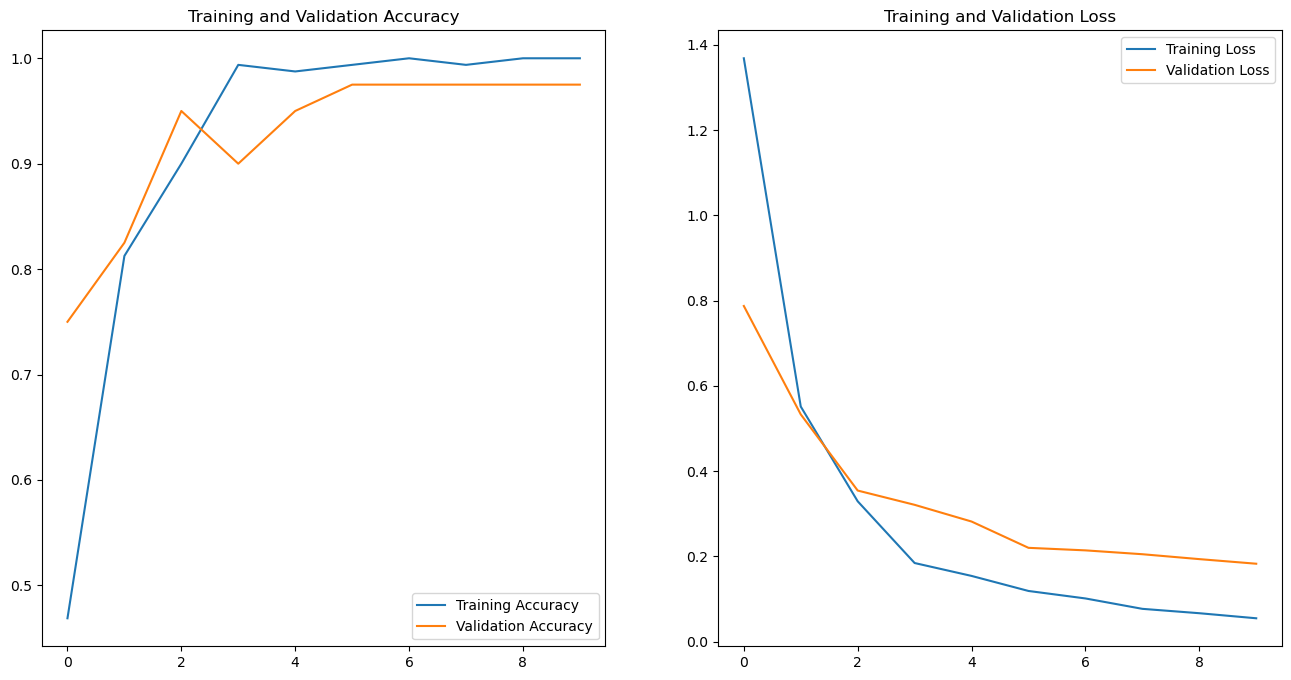

In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()
##################################################################
# # Define callbacks for early stopping and saving the best model
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
##################################################################

epochs = 10 # UPDATE WITH YOUR NUMBERS!!
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
  # callbacks=[early_stopping, model_checkpoint]
)

vis_history(history)

In [24]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all base model layers
print("And now let's enable trainable flag to the BASE MODEL: ")
base_model.trainable = True
for i, layer in enumerate(model.layers):
   print(i, layer.name, layer.trainable)

And now let's enable trainable flag to the BASE MODEL: 
0 input_8 True
1 sequential_3 True
2 tf.math.truediv_3 True
3 tf.math.subtract_3 True
4 mobilenetv2_1.00_224 True
5 global_average_pooling2d_3 True
6 dropout_3 True
7 dense_3 True


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_3 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_3 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                           

2024-11-20 21:04:55.791345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-20 21:04:56.726258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/40 [>.............................] - ETA: 6s - loss: 0.0239 - accuracy: 1.0000  

2024-11-20 21:04:59.918733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:00.082185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/40 [==>...........................] - ETA: 5s - loss: 0.0243 - accuracy: 1.0000

2024-11-20 21:05:00.230661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:00.367909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/40 [====>.........................] - ETA: 4s - loss: 0.0348 - accuracy: 1.0000

2024-11-20 21:05:00.454434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:00.545397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/40 [=====>........................] - ETA: 3s - loss: 0.0292 - accuracy: 1.0000

2024-11-20 21:05:00.658713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:00.765210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:00.856716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/40 [=======>......................] - ETA: 3s - loss: 0.0247 - accuracy: 1.0000

2024-11-20 21:05:00.935974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:01.016032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/40 [=========>....................] - ETA: 3s - loss: 0.0226 - accuracy: 1.0000

2024-11-20 21:05:01.246943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:01.323606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:01.399502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/40 [===========>..................] - ETA: 2s - loss: 0.0239 - accuracy: 1.0000

2024-11-20 21:05:01.477456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:01.589022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:01.666246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/40 [=============>................] - ETA: 2s - loss: 0.0250 - accuracy: 1.0000

2024-11-20 21:05:01.745015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/40 [==============>...............] - ETA: 2s - loss: 0.0234 - accuracy: 1.0000

2024-11-20 21:05:01.952101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:02.034621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:02.119605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/40 [=================>............] - ETA: 1s - loss: 0.0256 - accuracy: 1.0000

2024-11-20 21:05:02.197033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:02.273813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:02.363930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/40 [===================>..........] - ETA: 1s - loss: 0.0255 - accuracy: 1.0000

2024-11-20 21:05:02.448894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:02.524508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:02.604966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/40 [=====================>........] - ETA: 1s - loss: 0.0237 - accuracy: 1.0000

2024-11-20 21:05:02.679264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:02.756289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:02.831608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/40 [=======================>......] - ETA: 0s - loss: 0.0243 - accuracy: 1.0000

2024-11-20 21:05:02.909367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:03.004729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:03.082862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/40 [==========================>...] - ETA: 0s - loss: 0.0229 - accuracy: 1.0000

2024-11-20 21:05:03.161181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:03.240258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:03.315098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/40 [============================>.] - ETA: 0s - loss: 0.0213 - accuracy: 1.0000

2024-11-20 21:05:03.391755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:03.467637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:03.556476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/40 [==============================] - ETA: 0s - loss: 0.0279 - accuracy: 0.9937

2024-11-20 21:05:03.939687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 11s 126ms/step - loss: 0.0279 - accuracy: 0.9937 - val_loss: 0.1904 - val_accuracy: 0.9000
Epoch 2/10
 2/40 [>.............................] - ETA: 3s - loss: 0.0070 - accuracy: 1.0000

2024-11-20 21:05:04.804977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:04.911876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:04.990784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/40 [==>...........................] - ETA: 2s - loss: 0.0055 - accuracy: 1.0000

2024-11-20 21:05:05.070076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:05.153734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:05.236129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/40 [=====>........................] - ETA: 2s - loss: 0.0240 - accuracy: 1.0000

2024-11-20 21:05:05.311829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:05.393297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:05.468839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/40 [=======>......................] - ETA: 2s - loss: 0.0206 - accuracy: 1.0000

2024-11-20 21:05:05.544011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:05.621581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:05.695804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/40 [=========>....................] - ETA: 2s - loss: 0.0183 - accuracy: 1.0000

2024-11-20 21:05:05.803273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:05.886912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:05.961692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/40 [===========>..................] - ETA: 1s - loss: 0.0197 - accuracy: 1.0000

2024-11-20 21:05:06.038028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:06.114328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:06.188999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/40 [==============>...............] - ETA: 1s - loss: 0.0178 - accuracy: 1.0000

2024-11-20 21:05:06.263676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:06.342512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:06.417151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/40 [===============>..............] - ETA: 1s - loss: 0.0166 - accuracy: 1.0000

2024-11-20 21:05:06.492048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:06.656796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/40 [=================>............] - ETA: 1s - loss: 0.0206 - accuracy: 1.0000

2024-11-20 21:05:06.732914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:06.812037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:06.887033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/40 [====================>.........] - ETA: 0s - loss: 0.0211 - accuracy: 1.0000

2024-11-20 21:05:06.961505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:07.037578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:07.112028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/40 [======================>.......] - ETA: 0s - loss: 0.0214 - accuracy: 1.0000

2024-11-20 21:05:07.189278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:07.265650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:07.340059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/40 [========================>.....] - ETA: 0s - loss: 0.0207 - accuracy: 1.0000

2024-11-20 21:05:07.414194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:07.490369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:07.564631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/40 [==========================>...] - ETA: 0s - loss: 0.0205 - accuracy: 1.0000

2024-11-20 21:05:07.639379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:07.723941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:07.798787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/40 [==============================] - ETA: 0s - loss: 0.0210 - accuracy: 1.0000

2024-11-20 21:05:07.873988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:07.951160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/40 [==============================] - 4s 87ms/step - loss: 0.0210 - accuracy: 1.0000 - val_loss: 0.1379 - val_accuracy: 0.9750
Epoch 3/10
 2/40 [>.............................] - ETA: 3s - loss: 0.0066 - accuracy: 1.0000

2024-11-20 21:05:08.309098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:08.400926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:08.479646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/40 [==>...........................] - ETA: 3s - loss: 0.0048 - accuracy: 1.0000

2024-11-20 21:05:08.558235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:08.695484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/40 [====>.........................] - ETA: 2s - loss: 0.0123 - accuracy: 1.0000

2024-11-20 21:05:08.773454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:08.852022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:08.928083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/40 [======>.......................] - ETA: 2s - loss: 0.0090 - accuracy: 1.0000

2024-11-20 21:05:09.009663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:09.086541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:09.162066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/40 [========>.....................] - ETA: 2s - loss: 0.0106 - accuracy: 1.0000

2024-11-20 21:05:09.236955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:09.314159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:09.388255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/40 [===========>..................] - ETA: 1s - loss: 0.0110 - accuracy: 1.0000

2024-11-20 21:05:09.462814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:09.539972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:09.616494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/40 [=============>................] - ETA: 1s - loss: 0.0115 - accuracy: 1.0000

2024-11-20 21:05:09.694265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:09.806639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:09.888322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/40 [===============>..............] - ETA: 1s - loss: 0.0102 - accuracy: 1.0000

2024-11-20 21:05:09.966819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:10.056676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/40 [=================>............] - ETA: 1s - loss: 0.0101 - accuracy: 1.0000

2024-11-20 21:05:10.170682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:10.249656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:10.327213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/40 [===================>..........] - ETA: 1s - loss: 0.0097 - accuracy: 1.0000

2024-11-20 21:05:10.507095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:10.585236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:10.661520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/40 [=====================>........] - ETA: 0s - loss: 0.0091 - accuracy: 1.0000

2024-11-20 21:05:10.741696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:10.817817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:10.892962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/40 [=======================>......] - ETA: 0s - loss: 0.0083 - accuracy: 1.0000

2024-11-20 21:05:10.969319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:11.043392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:11.119140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/40 [==========================>...] - ETA: 0s - loss: 0.0077 - accuracy: 1.0000

2024-11-20 21:05:11.195767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:11.270307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:11.343467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/40 [============================>.] - ETA: 0s - loss: 0.0072 - accuracy: 1.0000

2024-11-20 21:05:11.417277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:11.492985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:11.572092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/40 [==============================] - 4s 90ms/step - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.1573 - val_accuracy: 0.9500
Epoch 4/10
 2/40 [>.............................] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000    

2024-11-20 21:05:11.908281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:11.986489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:12.064758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/40 [==>...........................] - ETA: 2s - loss: 0.0033 - accuracy: 1.0000

2024-11-20 21:05:12.143298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:12.217405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:12.290673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/40 [=====>........................] - ETA: 2s - loss: 0.0037 - accuracy: 1.0000

2024-11-20 21:05:12.364170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:12.442931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:12.520479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/40 [=======>......................] - ETA: 2s - loss: 0.0029 - accuracy: 1.0000

2024-11-20 21:05:12.594702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:12.674546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:12.764324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/40 [=========>....................] - ETA: 2s - loss: 0.0040 - accuracy: 1.0000

2024-11-20 21:05:12.852749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:12.927075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:13.002188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/40 [===========>..................] - ETA: 1s - loss: 0.0041 - accuracy: 1.0000

2024-11-20 21:05:13.077276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:13.151993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:13.229114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/40 [==============>...............] - ETA: 1s - loss: 0.0042 - accuracy: 1.0000

2024-11-20 21:05:13.327772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:13.421772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:13.495653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/40 [================>.............] - ETA: 1s - loss: 0.0038 - accuracy: 1.0000

2024-11-20 21:05:13.574828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:13.661693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:13.737011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/40 [==================>...........] - ETA: 1s - loss: 0.0037 - accuracy: 1.0000

2024-11-20 21:05:13.816749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:13.893162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:13.968095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/40 [====================>.........] - ETA: 0s - loss: 0.0042 - accuracy: 1.0000

2024-11-20 21:05:14.044704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:14.143806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:14.224171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/40 [=======================>......] - ETA: 0s - loss: 0.0039 - accuracy: 1.0000

2024-11-20 21:05:14.298963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:14.374067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:14.454681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/40 [=========================>....] - ETA: 0s - loss: 0.0038 - accuracy: 1.0000

2024-11-20 21:05:14.529131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:14.603353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:14.677952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/40 [===========================>..] - ETA: 0s - loss: 0.0038 - accuracy: 1.0000

2024-11-20 21:05:14.754120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:14.829706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:14.920476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/40 [==============================] - ETA: 0s - loss: 0.0037 - accuracy: 1.0000

2024-11-20 21:05:14.994442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/40 [==============================] - 3s 87ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.1591 - val_accuracy: 0.9500
Epoch 5/10
 2/40 [>.............................] - ETA: 2s - loss: 7.0089e-04 - accuracy: 1.0000

2024-11-20 21:05:15.396129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:15.471325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:15.546134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/40 [==>...........................] - ETA: 2s - loss: 0.0030 - accuracy: 1.0000

2024-11-20 21:05:15.621110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:15.698182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:15.777844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/40 [=====>........................] - ETA: 2s - loss: 0.0023 - accuracy: 1.0000

2024-11-20 21:05:15.854359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:15.928572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:16.003199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/40 [=======>......................] - ETA: 2s - loss: 0.0018 - accuracy: 1.0000

2024-11-20 21:05:16.076936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:16.152708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:16.241366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/40 [=========>....................] - ETA: 2s - loss: 0.0019 - accuracy: 1.0000

2024-11-20 21:05:16.327112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:16.401041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:16.474857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/40 [===========>..................] - ETA: 1s - loss: 0.0017 - accuracy: 1.0000

2024-11-20 21:05:16.557434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:16.631346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:16.705153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/40 [==============>...............] - ETA: 1s - loss: 0.0019 - accuracy: 1.0000

2024-11-20 21:05:16.777645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:16.852691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:16.925805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/40 [================>.............] - ETA: 1s - loss: 0.0018 - accuracy: 1.0000

2024-11-20 21:05:16.999257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:17.073740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:17.147472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/40 [==================>...........] - ETA: 1s - loss: 0.0020 - accuracy: 1.0000

2024-11-20 21:05:17.221140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:17.302363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:17.376437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/40 [====================>.........] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000

2024-11-20 21:05:17.449599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:17.525214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:17.599349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/40 [=======================>......] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

2024-11-20 21:05:17.672748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:17.746156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:17.819485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/40 [========================>.....] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

2024-11-20 21:05:17.895623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:18.021995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/40 [==========================>...] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

2024-11-20 21:05:18.101814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:18.177254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:18.264271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/40 [============================>.] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

2024-11-20 21:05:18.351347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:18.518239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/40 [==============================] - 3s 88ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.1476 - val_accuracy: 0.9500
Epoch 6/10
 1/40 [..............................] - ETA: 4s - loss: 0.0018 - accuracy: 1.0000

2024-11-20 21:05:18.892712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:19.017443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/40 [==>...........................] - ETA: 3s - loss: 0.0028 - accuracy: 1.0000

2024-11-20 21:05:19.098842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:19.208498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:19.298627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/40 [====>.........................] - ETA: 2s - loss: 0.0020 - accuracy: 1.0000

2024-11-20 21:05:19.373345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:19.448055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:19.521642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/40 [=====>........................] - ETA: 2s - loss: 0.0018 - accuracy: 1.0000

2024-11-20 21:05:19.607885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:19.774763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/40 [========>.....................] - ETA: 2s - loss: 0.0016 - accuracy: 1.0000

2024-11-20 21:05:19.850044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:19.950523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/40 [=========>....................] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

2024-11-20 21:05:20.051081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:20.126324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:20.208029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/40 [===========>..................] - ETA: 2s - loss: 0.0013 - accuracy: 1.0000

2024-11-20 21:05:20.300023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:20.390549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:20.472731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/40 [==============>...............] - ETA: 1s - loss: 0.0011 - accuracy: 1.0000

2024-11-20 21:05:20.565440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:20.649698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:20.742419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/40 [================>.............] - ETA: 1s - loss: 0.0012 - accuracy: 1.0000

2024-11-20 21:05:20.820594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:20.894615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:20.969844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/40 [==================>...........] - ETA: 1s - loss: 0.0011 - accuracy: 1.0000

2024-11-20 21:05:21.051667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:21.126486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:21.201747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/40 [====================>.........] - ETA: 1s - loss: 0.0011 - accuracy: 1.0000

2024-11-20 21:05:21.284555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/40 [=====================>........] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

2024-11-20 21:05:21.485453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:21.569180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:21.650923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/40 [=======================>......] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

2024-11-20 21:05:21.751039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:21.825745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:21.902084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/40 [==========================>...] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

2024-11-20 21:05:21.977379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:22.053602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:22.127665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/40 [============================>.] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

2024-11-20 21:05:22.208292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:22.284197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:22.358489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/40 [==============================] - 4s 93ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.1380 - val_accuracy: 0.9750
Epoch 7/10
 2/40 [>.............................] - ETA: 2s - loss: 2.6418e-04 - accuracy: 1.0000

2024-11-20 21:05:22.636312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:22.709550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:22.782784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/40 [==>...........................] - ETA: 2s - loss: 6.8524e-04 - accuracy: 1.0000

2024-11-20 21:05:22.856775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:22.930448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:23.003040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/40 [=====>........................] - ETA: 2s - loss: 0.0012 - accuracy: 1.0000

2024-11-20 21:05:23.082499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:23.174560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:23.248640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/40 [=======>......................] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

2024-11-20 21:05:23.324221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:23.398235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:23.471289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/40 [=========>....................] - ETA: 1s - loss: 0.0016 - accuracy: 1.0000

2024-11-20 21:05:23.544197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:23.623601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:23.695938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/40 [===========>..................] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

2024-11-20 21:05:23.768941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:23.843063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:23.916502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/40 [==============>...............] - ETA: 1s - loss: 0.0016 - accuracy: 1.0000

2024-11-20 21:05:23.990507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:24.063890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:24.137608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/40 [================>.............] - ETA: 1s - loss: 0.0016 - accuracy: 1.0000

2024-11-20 21:05:24.210411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:24.288786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:24.364810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/40 [==================>...........] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

2024-11-20 21:05:24.438402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:24.511833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:24.584621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/40 [====================>.........] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

2024-11-20 21:05:24.659085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:24.732948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:24.808378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/40 [=======================>......] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

2024-11-20 21:05:24.881692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:24.958177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:25.031154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/40 [=========================>....] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

2024-11-20 21:05:25.104745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:25.178446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:25.251076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/40 [===========================>..] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

2024-11-20 21:05:25.324763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:25.411848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:25.498049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/40 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

2024-11-20 21:05:25.575920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/40 [==============================] - 3s 80ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.1421 - val_accuracy: 0.9500
Epoch 8/10
 2/40 [>.............................] - ETA: 4s - loss: 4.4352e-04 - accuracy: 1.0000

2024-11-20 21:05:25.847470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:25.931531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/40 [==>...........................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000  

2024-11-20 21:05:26.049017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:26.127160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:26.204259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/40 [====>.........................] - ETA: 2s - loss: 0.0013 - accuracy: 1.0000

2024-11-20 21:05:26.281206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:26.358885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:26.436701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/40 [======>.......................] - ETA: 2s - loss: 0.0010 - accuracy: 1.0000

2024-11-20 21:05:26.514433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:26.589915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:26.667238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/40 [========>.....................] - ETA: 2s - loss: 8.9045e-04 - accuracy: 1.0000

2024-11-20 21:05:26.745801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:26.827651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:26.903190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/40 [===========>..................] - ETA: 1s - loss: 9.5641e-04 - accuracy: 1.0000

2024-11-20 21:05:26.986468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:27.073679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:27.164376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/40 [============>.................] - ETA: 1s - loss: 0.0010 - accuracy: 1.0000  

2024-11-20 21:05:27.283313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:27.408698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/40 [==============>...............] - ETA: 1s - loss: 0.0012 - accuracy: 1.0000

2024-11-20 21:05:27.509673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:27.587927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/40 [================>.............] - ETA: 1s - loss: 0.0012 - accuracy: 1.0000

2024-11-20 21:05:27.758898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:27.865853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:27.942028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/40 [==================>...........] - ETA: 1s - loss: 0.0011 - accuracy: 1.0000

2024-11-20 21:05:28.018791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:28.093458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:28.169414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/40 [====================>.........] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

2024-11-20 21:05:28.243841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:28.328577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:28.403726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/40 [=======================>......] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000

2024-11-20 21:05:28.478778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:28.557976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:28.639337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/40 [=========================>....] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

2024-11-20 21:05:28.713701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:28.788809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:28.863584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/40 [===========================>..] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

2024-11-20 21:05:28.938242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:29.025240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:29.101321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/40 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

2024-11-20 21:05:29.217915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/40 [==============================] - 4s 92ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.1081 - val_accuracy: 0.9750
Epoch 9/10
 2/40 [>.............................] - ETA: 2s - loss: 0.0033 - accuracy: 1.0000    

2024-11-20 21:05:29.507493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:29.580911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:29.654555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/40 [==>...........................] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

2024-11-20 21:05:29.729059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:29.805213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:29.879586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/40 [=====>........................] - ETA: 2s - loss: 0.0028 - accuracy: 1.0000

2024-11-20 21:05:29.953699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:30.026806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:30.103293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/40 [=======>......................] - ETA: 2s - loss: 0.0054 - accuracy: 1.0000

2024-11-20 21:05:30.181144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:30.254767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:30.328154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/40 [=========>....................] - ETA: 1s - loss: 0.0049 - accuracy: 1.0000

2024-11-20 21:05:30.404411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:30.482961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:30.557682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/40 [===========>..................] - ETA: 1s - loss: 0.0057 - accuracy: 1.0000

2024-11-20 21:05:30.631491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:30.706180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:30.782417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/40 [==============>...............] - ETA: 1s - loss: 0.0049 - accuracy: 1.0000

2024-11-20 21:05:30.857674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:30.932701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:31.006343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/40 [================>.............] - ETA: 1s - loss: 0.0043 - accuracy: 1.0000

2024-11-20 21:05:31.084554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:31.163215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:31.235836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/40 [==================>...........] - ETA: 1s - loss: 0.0040 - accuracy: 1.0000

2024-11-20 21:05:31.309811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:31.384878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:31.461663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/40 [====================>.........] - ETA: 0s - loss: 0.0036 - accuracy: 1.0000

2024-11-20 21:05:31.550682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:31.624515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:31.699855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/40 [=====================>........] - ETA: 0s - loss: 0.0035 - accuracy: 1.0000

2024-11-20 21:05:31.818923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/40 [=======================>......] - ETA: 0s - loss: 0.0033 - accuracy: 1.0000

2024-11-20 21:05:32.056665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:32.142270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:32.218925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/40 [==========================>...] - ETA: 0s - loss: 0.0034 - accuracy: 1.0000

2024-11-20 21:05:32.295449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:32.373588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:32.480715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/40 [============================>.] - ETA: 0s - loss: 0.0039 - accuracy: 1.0000

2024-11-20 21:05:32.576385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:32.655140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:32.727610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/40 [==============================] - 3s 88ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.1640 - val_accuracy: 0.9250
Epoch 10/10
 2/40 [>.............................] - ETA: 2s - loss: 4.5057e-04 - accuracy: 1.0000

2024-11-20 21:05:33.000262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:33.072989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:33.146122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/40 [==>...........................] - ETA: 2s - loss: 2.1084e-04 - accuracy: 1.0000

2024-11-20 21:05:33.221611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:33.295623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:33.370675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/40 [=====>........................] - ETA: 2s - loss: 5.9508e-04 - accuracy: 1.0000

2024-11-20 21:05:33.451570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:33.526121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:33.642972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/40 [=======>......................] - ETA: 2s - loss: 4.4634e-04 - accuracy: 1.0000

2024-11-20 21:05:33.728620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:33.811681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:33.886821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/40 [=========>....................] - ETA: 2s - loss: 4.6249e-04 - accuracy: 1.0000

2024-11-20 21:05:33.961991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:34.038903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:34.112920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/40 [===========>..................] - ETA: 1s - loss: 5.3010e-04 - accuracy: 1.0000

2024-11-20 21:05:34.186455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:34.263552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:34.337039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/40 [==============>...............] - ETA: 1s - loss: 0.0048 - accuracy: 1.0000

2024-11-20 21:05:34.413102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:34.486241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:34.561875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/40 [================>.............] - ETA: 1s - loss: 0.0043 - accuracy: 1.0000

2024-11-20 21:05:34.649172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:34.725709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:34.810711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/40 [==================>...........] - ETA: 1s - loss: 0.0038 - accuracy: 1.0000

2024-11-20 21:05:34.888015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:34.965192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:35.039636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/40 [====================>.........] - ETA: 0s - loss: 0.0035 - accuracy: 1.0000

2024-11-20 21:05:35.165915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:35.254977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:35.329116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/40 [=======================>......] - ETA: 0s - loss: 0.0032 - accuracy: 1.0000

2024-11-20 21:05:35.405049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:35.482627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:35.558633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/40 [=========================>....] - ETA: 0s - loss: 0.0142 - accuracy: 0.9929

2024-11-20 21:05:35.638821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:35.721075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:35.795430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/40 [===========================>..] - ETA: 0s - loss: 0.0131 - accuracy: 0.9934

2024-11-20 21:05:35.872691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:35.950453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:05:36.024545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/40 [==============================] - ETA: 0s - loss: 0.0171 - accuracy: 0.9937

2024-11-20 21:05:36.099324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/40 [==============================] - 3s 86ms/step - loss: 0.0171 - accuracy: 0.9937 - val_loss: 0.0884 - val_accuracy: 0.9750


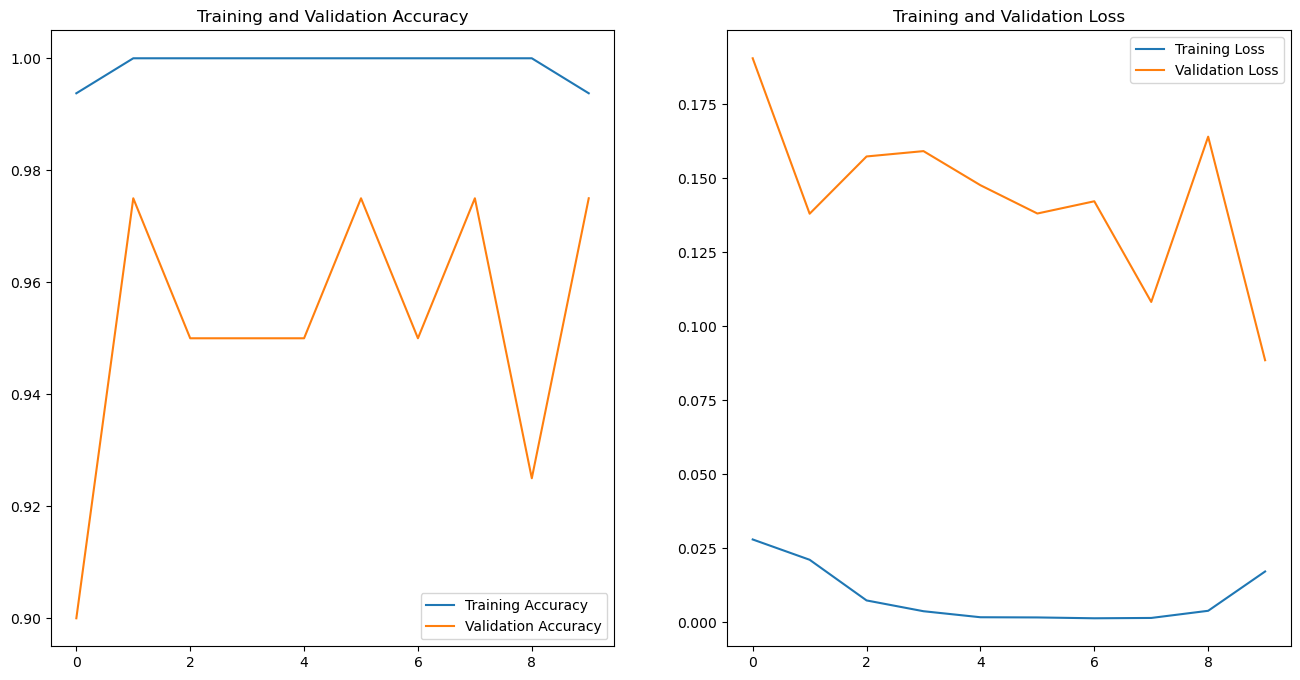

In [ ]:
epochs = 10 # UPDATE WITH YOUR NUMBERS!!

base_learning_rate = 0.00001 ## Learning rate lower than when training the top layers

# # Fine-tune specific layers of the base model
# for layer in base_model.layers[:-50]:  # Freeze the first 50 layers
#     layer.trainable = False


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()
history2 = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
vis_history(history2)

# Save the model
model.save('last_finetuned_model_V1.keras')

As a **final experiment, run a few (ONLY 2 or 3) variations to see HOW/IF your changes influence the results**.
- You can change learning rates (where do you think it makes sense to use smaller? larger?), optimizers, batch size, ...
- INSTEAD of just SAVING THE LAST MODEL. you can add this callback to save "check points" of your model (in this case is set to save only the best one found).
More info: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

You can add plenty of other "utilities" to run during your training process.
More info: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks

In [26]:
checkpoint_filepath = './tmp/checkpoint.weights.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True)

# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
history2 = model.fit(
 train_ds,
 validation_data=val_ds,
 epochs=epochs,
 callbacks=[model_checkpoint_callback]
)


Epoch 1/10


2024-11-20 21:18:13.604928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/40 [=>............................] - ETA: 3s - loss: 0.0249 - accuracy: 1.0000   

2024-11-20 21:18:13.866843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:13.957641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:14.035215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/40 [==>...........................] - ETA: 3s - loss: 0.0423 - accuracy: 1.0000

2024-11-20 21:18:14.126387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:14.297910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/40 [=====>........................] - ETA: 3s - loss: 0.0347 - accuracy: 1.0000

2024-11-20 21:18:14.400806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:14.488362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:14.564242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/40 [=======>......................] - ETA: 2s - loss: 0.0571 - accuracy: 0.9773

2024-11-20 21:18:14.644028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:14.743023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:14.818953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/40 [=========>....................] - ETA: 2s - loss: 0.0461 - accuracy: 0.9821

2024-11-20 21:18:14.900154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:14.976724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:15.052061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/40 [===========>..................] - ETA: 2s - loss: 0.1145 - accuracy: 0.9375

2024-11-20 21:18:15.127257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:15.289321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/40 [=============>................] - ETA: 1s - loss: 0.0970 - accuracy: 0.9474

2024-11-20 21:18:15.366133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:15.453392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:15.529726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/40 [===============>..............] - ETA: 1s - loss: 0.0840 - accuracy: 0.9545

2024-11-20 21:18:15.606182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:15.683265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:15.759740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/40 [=================>............] - ETA: 1s - loss: 0.0885 - accuracy: 0.9500

2024-11-20 21:18:15.837715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:15.915164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:15.992256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/40 [====================>.........] - ETA: 1s - loss: 0.0807 - accuracy: 0.9554

2024-11-20 21:18:16.078066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:16.157514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:16.233162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/40 [=====================>........] - ETA: 0s - loss: 0.0885 - accuracy: 0.9500

2024-11-20 21:18:16.310857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:16.455017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/40 [=======================>......] - ETA: 0s - loss: 0.0983 - accuracy: 0.9394

2024-11-20 21:18:16.532510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:16.610119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:16.684622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/40 [==========================>...] - ETA: 0s - loss: 0.0905 - accuracy: 0.9444

2024-11-20 21:18:16.760927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:16.838955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:16.913257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/40 [============================>.] - ETA: 0s - loss: 0.0837 - accuracy: 0.9487

2024-11-20 21:18:16.989728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:17.067472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:17.148892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/40 [==============================] - 4s 100ms/step - loss: 0.0816 - accuracy: 0.9500 - val_loss: 0.1272 - val_accuracy: 0.9250
Epoch 2/10
 2/40 [>.............................] - ETA: 2s - loss: 0.0045 - accuracy: 1.0000

2024-11-20 21:18:17.761845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:17.842462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:17.919563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/40 [==>...........................] - ETA: 2s - loss: 0.1461 - accuracy: 0.9500

2024-11-20 21:18:17.996405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:18.084775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:18.164301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/40 [=====>........................] - ETA: 2s - loss: 0.1316 - accuracy: 0.9688

2024-11-20 21:18:18.298096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:18.397001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:18.472549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/40 [=======>......................] - ETA: 2s - loss: 0.0965 - accuracy: 0.9773

2024-11-20 21:18:18.551860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:18.629877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:18.705972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/40 [=========>....................] - ETA: 2s - loss: 0.0812 - accuracy: 0.9821

2024-11-20 21:18:18.783683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:18.863105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:18.939963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/40 [===========>..................] - ETA: 1s - loss: 0.0912 - accuracy: 0.9706

2024-11-20 21:18:19.019907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:19.101657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:19.175714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/40 [==============>...............] - ETA: 1s - loss: 0.0781 - accuracy: 0.9750

2024-11-20 21:18:19.254992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:19.332839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:19.409157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/40 [================>.............] - ETA: 1s - loss: 0.0695 - accuracy: 0.9783

2024-11-20 21:18:19.489292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:19.566637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:19.643481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/40 [==================>...........] - ETA: 1s - loss: 0.0648 - accuracy: 0.9808

2024-11-20 21:18:19.721800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:19.800996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:19.875751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/40 [====================>.........] - ETA: 0s - loss: 0.0697 - accuracy: 0.9741

2024-11-20 21:18:20.020474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:20.113970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:20.188372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/40 [=======================>......] - ETA: 0s - loss: 0.0635 - accuracy: 0.9766

2024-11-20 21:18:20.268128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:20.348786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:20.423903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/40 [=========================>....] - ETA: 0s - loss: 0.0584 - accuracy: 0.9786

2024-11-20 21:18:20.508249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:20.584855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:20.659614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/40 [===========================>..] - ETA: 0s - loss: 0.0556 - accuracy: 0.9803

2024-11-20 21:18:20.737764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:20.819108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:20.898263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/40 [==============================] - ETA: 0s - loss: 0.0528 - accuracy: 0.9812

2024-11-20 21:18:20.974269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/40 [==============================] - 4s 95ms/step - loss: 0.0528 - accuracy: 0.9812 - val_loss: 0.1801 - val_accuracy: 0.9250
Epoch 3/10
 2/40 [>.............................] - ETA: 2s - loss: 6.2131e-04 - accuracy: 1.0000

2024-11-20 21:18:21.565423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:21.647165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:21.727167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/40 [==>...........................] - ETA: 2s - loss: 0.0049 - accuracy: 1.0000  

2024-11-20 21:18:21.805881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:21.884491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:21.961326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/40 [=====>........................] - ETA: 2s - loss: 0.0039 - accuracy: 1.0000

2024-11-20 21:18:22.109107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:22.207200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:22.282822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/40 [=======>......................] - ETA: 2s - loss: 0.0038 - accuracy: 1.0000

2024-11-20 21:18:22.361058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:22.442292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:22.517053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/40 [=========>....................] - ETA: 2s - loss: 0.0036 - accuracy: 1.0000

2024-11-20 21:18:22.591856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:22.673420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:22.754194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/40 [===========>..................] - ETA: 1s - loss: 0.0032 - accuracy: 1.0000

2024-11-20 21:18:22.840420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:22.922161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:22.997449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/40 [==============>...............] - ETA: 1s - loss: 0.0028 - accuracy: 1.0000

2024-11-20 21:18:23.076783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:23.155371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:23.230302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/40 [================>.............] - ETA: 1s - loss: 0.0025 - accuracy: 1.0000

2024-11-20 21:18:23.356836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:23.464706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:23.539528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/40 [==================>...........] - ETA: 1s - loss: 0.0024 - accuracy: 1.0000

2024-11-20 21:18:23.621001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:23.698081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:23.772876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/40 [====================>.........] - ETA: 0s - loss: 0.0024 - accuracy: 1.0000

2024-11-20 21:18:23.848456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:23.936171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:24.010556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/40 [=======================>......] - ETA: 0s - loss: 0.0029 - accuracy: 1.0000

2024-11-20 21:18:24.088823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:24.166400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:24.240528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/40 [=========================>....] - ETA: 0s - loss: 0.0029 - accuracy: 1.0000

2024-11-20 21:18:24.317720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:24.400369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:24.477363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/40 [===========================>..] - ETA: 0s - loss: 0.0027 - accuracy: 1.0000

2024-11-20 21:18:24.555084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:24.645913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:24.723641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/40 [==============================] - ETA: 0s - loss: 0.0026 - accuracy: 1.0000

2024-11-20 21:18:24.807718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/40 [==============================] - 4s 99ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.1537 - val_accuracy: 0.9500
Epoch 4/10
 2/40 [>.............................] - ETA: 2s - loss: 0.0225 - accuracy: 1.0000    

2024-11-20 21:18:25.507428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:25.591927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:25.668963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/40 [==>...........................] - ETA: 2s - loss: 0.0103 - accuracy: 1.0000

2024-11-20 21:18:25.755589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:25.837381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:25.912868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/40 [=====>........................] - ETA: 2s - loss: 0.0074 - accuracy: 1.0000

2024-11-20 21:18:25.989089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:26.067618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:26.145097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/40 [=======>......................] - ETA: 2s - loss: 0.0062 - accuracy: 1.0000

2024-11-20 21:18:26.222355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:26.302438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:26.379716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/40 [=========>....................] - ETA: 2s - loss: 0.0053 - accuracy: 1.0000

2024-11-20 21:18:26.521314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:26.608194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:26.682698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/40 [===========>..................] - ETA: 1s - loss: 0.0045 - accuracy: 1.0000

2024-11-20 21:18:26.760498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:26.838762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:26.914260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/40 [==============>...............] - ETA: 1s - loss: 0.0039 - accuracy: 1.0000

2024-11-20 21:18:26.989937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:27.069488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:27.145719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/40 [================>.............] - ETA: 1s - loss: 0.0036 - accuracy: 1.0000

2024-11-20 21:18:27.224417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:27.308701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:27.383781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/40 [==================>...........] - ETA: 1s - loss: 0.0035 - accuracy: 1.0000

2024-11-20 21:18:27.460871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:27.538969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:27.613376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/40 [====================>.........] - ETA: 0s - loss: 0.0032 - accuracy: 1.0000

2024-11-20 21:18:27.689885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:27.768045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:27.854482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/40 [=======================>......] - ETA: 0s - loss: 0.0031 - accuracy: 1.0000

2024-11-20 21:18:27.970692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:28.059454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:28.137956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/40 [=========================>....] - ETA: 0s - loss: 0.0030 - accuracy: 1.0000

2024-11-20 21:18:28.222023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:28.299271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:28.374089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/40 [===========================>..] - ETA: 0s - loss: 0.0028 - accuracy: 1.0000

2024-11-20 21:18:28.452922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:28.536097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:28.613507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/40 [==============================] - ETA: 0s - loss: 0.0028 - accuracy: 1.0000

2024-11-20 21:18:28.690361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/40 [==============================] - 3s 87ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.1659 - val_accuracy: 0.9500
Epoch 5/10
 2/40 [>.............................] - ETA: 2s - loss: 0.0012 - accuracy: 1.0000

2024-11-20 21:18:28.994674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:29.081620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:29.158054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/40 [==>...........................] - ETA: 2s - loss: 0.0013 - accuracy: 1.0000

2024-11-20 21:18:29.235712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:29.314737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:29.391043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/40 [====>.........................] - ETA: 2s - loss: 0.0012 - accuracy: 1.0000

2024-11-20 21:18:29.472346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:29.622860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/40 [======>.......................] - ETA: 2s - loss: 9.8459e-04 - accuracy: 1.0000

2024-11-20 21:18:29.699501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:29.778107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:29.860920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/40 [========>.....................] - ETA: 2s - loss: 8.9631e-04 - accuracy: 1.0000

2024-11-20 21:18:29.940168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:30.024944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:30.101145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/40 [===========>..................] - ETA: 2s - loss: 7.5630e-04 - accuracy: 1.0000

2024-11-20 21:18:30.182943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:30.264403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:30.341921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/40 [=============>................] - ETA: 1s - loss: 8.4249e-04 - accuracy: 1.0000

2024-11-20 21:18:30.422640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:30.502026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:30.575692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/40 [===============>..............] - ETA: 1s - loss: 8.5600e-04 - accuracy: 1.0000

2024-11-20 21:18:30.651178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:30.729650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:30.805148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/40 [=================>............] - ETA: 1s - loss: 8.3876e-04 - accuracy: 1.0000

2024-11-20 21:18:30.880813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:31.067335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/40 [===================>..........] - ETA: 1s - loss: 9.8275e-04 - accuracy: 1.0000

2024-11-20 21:18:31.149854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:31.233178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:31.312093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/40 [=====================>........] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000  

2024-11-20 21:18:31.387957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:31.467831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:31.542020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/40 [=======================>......] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

2024-11-20 21:18:31.619534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:31.705661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:31.781112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/40 [=========================>....] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

2024-11-20 21:18:31.857398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:31.995822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/40 [===========================>..] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

2024-11-20 21:18:32.075708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:32.162501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:32.239564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/40 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

2024-11-20 21:18:32.313674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/40 [==============================] - 4s 90ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.1612 - val_accuracy: 0.9500
Epoch 6/10
 2/40 [>.............................] - ETA: 2s - loss: 4.9246e-04 - accuracy: 1.0000

2024-11-20 21:18:32.596263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:32.669992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:32.743304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/40 [==>...........................] - ETA: 2s - loss: 3.9005e-04 - accuracy: 1.0000

2024-11-20 21:18:32.819485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:32.892440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:32.966042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/40 [=====>........................] - ETA: 2s - loss: 0.0020 - accuracy: 1.0000

2024-11-20 21:18:33.068817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:33.158732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:33.234546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/40 [=======>......................] - ETA: 2s - loss: 0.0018 - accuracy: 1.0000

2024-11-20 21:18:33.366614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:33.455500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:33.532040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/40 [=========>....................] - ETA: 2s - loss: 0.0019 - accuracy: 1.0000

2024-11-20 21:18:33.612183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:33.701887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:33.776721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/40 [===========>..................] - ETA: 1s - loss: 0.0018 - accuracy: 1.0000

2024-11-20 21:18:33.854317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:33.931728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:34.007005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/40 [==============>...............] - ETA: 1s - loss: 0.0016 - accuracy: 1.0000

2024-11-20 21:18:34.083322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:34.184654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:34.258408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/40 [================>.............] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

2024-11-20 21:18:34.337856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:34.415700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:34.490115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/40 [==================>...........] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

2024-11-20 21:18:34.566572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:34.648716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:34.730146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/40 [====================>.........] - ETA: 1s - loss: 0.0021 - accuracy: 1.0000

2024-11-20 21:18:34.830821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:34.975253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/40 [======================>.......] - ETA: 0s - loss: 0.0021 - accuracy: 1.0000

2024-11-20 21:18:35.053282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:35.132223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:35.207047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/40 [========================>.....] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

2024-11-20 21:18:35.286961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:35.368112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:35.441990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/40 [==========================>...] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

2024-11-20 21:18:35.520487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:35.598379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:35.674588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/40 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

2024-11-20 21:18:35.750538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:35.828642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/40 [==============================] - 4s 88ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.1489 - val_accuracy: 0.9500
Epoch 7/10
 2/40 [>.............................] - ETA: 2s - loss: 6.6884e-04 - accuracy: 1.0000

2024-11-20 21:18:36.120070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:36.198417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:36.274176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/40 [==>...........................] - ETA: 3s - loss: 3.7057e-04 - accuracy: 1.0000

2024-11-20 21:18:36.350664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:36.506630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/40 [====>.........................] - ETA: 2s - loss: 3.2307e-04 - accuracy: 1.0000

2024-11-20 21:18:36.585358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:36.661772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:36.736446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/40 [======>.......................] - ETA: 2s - loss: 3.0165e-04 - accuracy: 1.0000

2024-11-20 21:18:36.811178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:36.900644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:36.983647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/40 [========>.....................] - ETA: 2s - loss: 3.9138e-04 - accuracy: 1.0000

2024-11-20 21:18:37.064036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:37.145751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:37.224987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/40 [===========>..................] - ETA: 2s - loss: 7.7673e-04 - accuracy: 1.0000

2024-11-20 21:18:37.303238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:37.383333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:37.457731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/40 [=============>................] - ETA: 1s - loss: 7.1077e-04 - accuracy: 1.0000

2024-11-20 21:18:37.534131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:37.614370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:37.689630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/40 [===============>..............] - ETA: 1s - loss: 7.5960e-04 - accuracy: 1.0000

2024-11-20 21:18:37.765355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:37.843943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:37.919807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/40 [=================>............] - ETA: 1s - loss: 8.5342e-04 - accuracy: 1.0000

2024-11-20 21:18:38.049692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:38.141666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:38.216922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/40 [====================>.........] - ETA: 1s - loss: 8.6587e-04 - accuracy: 1.0000

2024-11-20 21:18:38.294886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:38.374671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:38.448865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/40 [======================>.......] - ETA: 0s - loss: 8.1414e-04 - accuracy: 1.0000

2024-11-20 21:18:38.523914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:38.603087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:38.676839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/40 [========================>.....] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000    

2024-11-20 21:18:38.755462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:38.848124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:38.927152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/40 [==========================>...] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

2024-11-20 21:18:39.070500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:39.152307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:39.230434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/40 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

2024-11-20 21:18:39.349462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:39.439225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/40 [==============================] - 4s 90ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.1256 - val_accuracy: 0.9500
Epoch 8/10
 2/40 [>.............................] - ETA: 2s - loss: 2.6859e-04 - accuracy: 1.0000

2024-11-20 21:18:39.717906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:39.801277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:39.877504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/40 [==>...........................] - ETA: 2s - loss: 2.2620e-04 - accuracy: 1.0000

2024-11-20 21:18:39.954698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:40.035433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:40.109717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/40 [=====>........................] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000  

2024-11-20 21:18:40.239347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:40.332608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:40.407584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/40 [=======>......................] - ETA: 2s - loss: 0.0013 - accuracy: 1.0000

2024-11-20 21:18:40.483547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:40.562467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:40.636549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/40 [=========>....................] - ETA: 2s - loss: 0.0013 - accuracy: 1.0000

2024-11-20 21:18:40.711203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:40.791481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:40.868627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/40 [===========>..................] - ETA: 1s - loss: 0.0011 - accuracy: 1.0000

2024-11-20 21:18:40.944703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:41.024290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:41.099157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/40 [=============>................] - ETA: 1s - loss: 0.0011 - accuracy: 1.0000

2024-11-20 21:18:41.174894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:41.318644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/40 [===============>..............] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

2024-11-20 21:18:41.411103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:41.504526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:41.586536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/40 [=================>............] - ETA: 1s - loss: 0.0012 - accuracy: 1.0000

2024-11-20 21:18:41.687995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:41.769074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:41.843740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/40 [====================>.........] - ETA: 1s - loss: 0.0011 - accuracy: 1.0000

2024-11-20 21:18:41.927243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:42.010892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:42.085588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/40 [=====================>........] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

2024-11-20 21:18:42.161518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:42.310449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/40 [=======================>......] - ETA: 0s - loss: 9.9315e-04 - accuracy: 1.0000

2024-11-20 21:18:42.388726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:42.470073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:42.544539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/40 [==========================>...] - ETA: 0s - loss: 0.0010 - accuracy: 1.0000    

2024-11-20 21:18:42.621297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:42.704822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:42.781300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/40 [============================>.] - ETA: 0s - loss: 9.7623e-04 - accuracy: 1.0000

2024-11-20 21:18:42.859847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:42.945636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:43.020685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/40 [==============================] - 4s 90ms/step - loss: 9.5561e-04 - accuracy: 1.0000 - val_loss: 0.1068 - val_accuracy: 0.9750
Epoch 9/10
 2/40 [>.............................] - ETA: 2s - loss: 2.5966e-04 - accuracy: 1.0000

2024-11-20 21:18:43.324006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:43.402592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:43.482059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/40 [==>...........................] - ETA: 3s - loss: 2.4041e-04 - accuracy: 1.0000

2024-11-20 21:18:43.646299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:43.749677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:43.829485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/40 [=====>........................] - ETA: 3s - loss: 0.0015 - accuracy: 1.0000

2024-11-20 21:18:43.908507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:43.986421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:44.059905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/40 [=======>......................] - ETA: 2s - loss: 0.0012 - accuracy: 1.0000

2024-11-20 21:18:44.139669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:44.222517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:44.297778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/40 [=========>....................] - ETA: 2s - loss: 0.0010 - accuracy: 1.0000

2024-11-20 21:18:44.373499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:44.452686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:44.527475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/40 [===========>..................] - ETA: 2s - loss: 8.8424e-04 - accuracy: 1.0000

2024-11-20 21:18:44.607365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:44.746943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/40 [=============>................] - ETA: 1s - loss: 7.6886e-04 - accuracy: 1.0000

2024-11-20 21:18:44.833199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:44.919354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:44.992842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/40 [===============>..............] - ETA: 1s - loss: 6.8299e-04 - accuracy: 1.0000

2024-11-20 21:18:45.070073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:45.147935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:45.222477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/40 [=================>............] - ETA: 1s - loss: 6.4952e-04 - accuracy: 1.0000

2024-11-20 21:18:45.297631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:45.376859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:45.451135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/40 [====================>.........] - ETA: 1s - loss: 6.0306e-04 - accuracy: 1.0000

2024-11-20 21:18:45.528097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:45.608025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:45.682621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/40 [======================>.......] - ETA: 0s - loss: 5.8134e-04 - accuracy: 1.0000

2024-11-20 21:18:45.759393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:45.850214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:45.924784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/40 [=======================>......] - ETA: 0s - loss: 5.7122e-04 - accuracy: 1.0000

2024-11-20 21:18:46.000290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:46.143418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/40 [==========================>...] - ETA: 0s - loss: 8.6461e-04 - accuracy: 1.0000

2024-11-20 21:18:46.224849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:46.311975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:46.386780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/40 [============================>.] - ETA: 0s - loss: 8.2302e-04 - accuracy: 1.0000

2024-11-20 21:18:46.463049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:46.542313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:46.617095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/40 [==============================] - 4s 89ms/step - loss: 8.1644e-04 - accuracy: 1.0000 - val_loss: 0.1212 - val_accuracy: 0.9500
Epoch 10/10
 2/40 [>.............................] - ETA: 2s - loss: 4.0209e-04 - accuracy: 1.0000

2024-11-20 21:18:46.885613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:46.962703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:47.039431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/40 [==>...........................] - ETA: 2s - loss: 7.9571e-04 - accuracy: 1.0000

2024-11-20 21:18:47.115268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:47.194342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:47.269702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/40 [====>.........................] - ETA: 2s - loss: 6.3223e-04 - accuracy: 1.0000

2024-11-20 21:18:47.348586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:47.486485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/40 [======>.......................] - ETA: 2s - loss: 5.4124e-04 - accuracy: 1.0000

2024-11-20 21:18:47.566697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:47.664101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:47.743310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/40 [========>.....................] - ETA: 2s - loss: 4.9910e-04 - accuracy: 1.0000

2024-11-20 21:18:47.822671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:47.900295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:47.974983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/40 [===========>..................] - ETA: 1s - loss: 4.8595e-04 - accuracy: 1.0000

2024-11-20 21:18:48.056322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:48.135068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:48.210781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/40 [=============>................] - ETA: 1s - loss: 4.5565e-04 - accuracy: 1.0000

2024-11-20 21:18:48.289690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:48.369678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:48.446915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/40 [===============>..............] - ETA: 1s - loss: 4.3074e-04 - accuracy: 1.0000

2024-11-20 21:18:48.524491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:48.602786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:48.676269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/40 [=================>............] - ETA: 1s - loss: 4.7639e-04 - accuracy: 1.0000

2024-11-20 21:18:48.752928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:48.832328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:48.919321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/40 [====================>.........] - ETA: 0s - loss: 4.6746e-04 - accuracy: 1.0000

2024-11-20 21:18:49.047206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:49.134599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:49.208892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/40 [======================>.......] - ETA: 0s - loss: 4.8102e-04 - accuracy: 1.0000

2024-11-20 21:18:49.289153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:49.369610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:49.445135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/40 [========================>.....] - ETA: 0s - loss: 4.5642e-04 - accuracy: 1.0000

2024-11-20 21:18:49.521347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:49.607378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:49.682611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/40 [==========================>...] - ETA: 0s - loss: 4.4940e-04 - accuracy: 1.0000

2024-11-20 21:18:49.759680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:49.839821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:49.914899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/40 [==============================] - ETA: 0s - loss: 5.3448e-04 - accuracy: 1.0000

2024-11-20 21:18:49.990171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-20 21:18:50.072101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/40 [==============================] - 3s 87ms/step - loss: 5.3448e-04 - accuracy: 1.0000 - val_loss: 0.1229 - val_accuracy: 0.9500


### **QUESTION 1**. Answer True/False and explain why you think so.

1. After reading the explanations in this notebook, I think when fine-tuning and existing model, we usually start with its layers frozen, but later we should un-freeze *ALL* layers always.

2.   It is essential to make sure when loading the base model, its parameter *weights* are initialized to the pre-trained weigths we want, usually imagenet.



ANSWER 1: 

1. False. It is not necessary to un-freeze ALL layers, in fact, keeping the earlier layers frozen allows the model to retain valuable low-level features learned from the base model, which are often generalizable across tasks. Additionally, this approach saves computation time and reduces the risk of overfitting.


2. True. This allows us to leverage the learned features from the large dataset and adapt them to our specific task. Without initializing with pre-trained weights, the model would lose the benefit of transfer learning, effectively starting from scratch.

### **QUESTION 2**.
Discuss the results you have obtained with your toy-data after running the different steps of the fine tunning process and the variations you have incorporated.

* How does it compare to the previous tasks in this Lab 3? What are advantages/disadvantages you find within each option? (max 10 lines).


ANSWER 2: 


1.	Dropout to 0.3: This helped mitigate overfitting by adding regularization. However, excessive dropout can slow down convergence by discarding too much information during training.

2.	Early stopping and model checkpoint: These additions ensured efficient training, avoiding overfitting by halting when validation performance plateaued. Model checkpointing further safeguarded the best-performing model, improving reliability in case of overtraining in later epochs.

3.	Freezing the first 50 layers: Retaining the general feature extraction capabilities of the base model allowed us to focus on adapting deeper, task-specific layers. This approach reduced computational load and preserved learned information from the pre-trained weights.

4.	Lower learning rate for fine-tuning: A reduced learning rate enabled more precise updates to the weights during fine-tuning, preventing drastic changes that could overwrite useful pre-trained knowledge.

